# Uncover the factors to help measure how young children learn

### Setting Up

In [41]:
# System management
import os
import gc

# Numpy and pandas for data analysis and manipulation
import numpy as np
import pandas as pd

# Json for converting string to dict
import json

# Random for random
import random

# Datetime for handling date time variables
import datetime as dt

# Matplotlib pyplot and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms
from sklearn.ensemble import RandomForestClassifier as rf
from xgboost import XGBClassifier as xgb
from lightgbm import LGBMClassifier as lgbm
from lightgbm import LGBMRegressor

# Sklearn importing folding methods
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

# Sklearn importing evaluation metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix

# For shuffling Groups
from sklearn.utils import shuffle

# Hyper paramater optimisation
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt.fmin import fmin

# Weights and Biases for model control
import wandb

# tqdm for progress management
from tqdm import tqdm
tqdm.pandas()

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [46]:
# Setting up
config = {
    'method': 'LightGBM',
    'debug': True,
    'debug_train_size': 100,
    'debug_test_size': 50,
    'random_seed': 42,
    'num_trials': 10
}

### Functions

In [47]:
def ml_encoder(train, test, encode_columns, threshold=999, nan_as_category=True):
    """
    One-hot and label encoder with thresholds for categorical columns
    """
    # Union train and test to make sure all categories are represented
    df = pd.concat([train, test], ignore_index=True)
    
    # Unchanged columns
    keep_df = df[df.columns[~df.columns.isin(encode_columns)]]

    # Number of categories
    num_categories = df[encode_columns].describe(include='all').loc['unique']
    
    # Label encoding
    label_columns = num_categories.where(num_categories >= threshold).dropna().index
    le = LabelEncoder()
    label_df = df[label_columns].apply(lambda col: le.fit_transform(col))
    label_df = label_df.fillna(0).astype(np.int32)
    if label_df.shape[0] != 0:
        keep_label_df = pd.concat([keep_df, label_df], axis=1, sort=True)
        del keep_df, label_df
    else:
        keep_label_df = keep_df
        del keep_df
        
    # One hot encoding
    one_hot_columns = num_categories.where(num_categories < threshold).dropna().index

    one_hot_df = pd.get_dummies(df[one_hot_columns], dummy_na=nan_as_category)
    one_hot_df.columns = [f"{col}" for col in one_hot_df.columns]
    one_hot_df = one_hot_df.fillna(0).astype(np.int32)
    if one_hot_df.shape[0] != 0:
        df = pd.concat([keep_label_df, one_hot_df], axis=1, sort=True)
        del keep_label_df
    else:
        df = keep_label_df
        del keep_label_df
        
    train = df.iloc[:len(train.index)].reset_index().drop(columns=['index'])
    test = df.iloc[len(train.index):].reset_index().drop(columns=['index'])
    
    return train, test, le

In [48]:
def json_to_columns(train, test, json_columns):
    """
    Splits out json columns
    """
    # Union train and test to make sure all categories are represented
    df = pd.concat([train, test], ignore_index=True)
    
    # Base to make the new datafram from
    base_df = df[df.columns[~df.columns.isin(json_columns)]]

    for column in json_columns:
        json_df = pd.DataFrame(df[column].apply(json.loads).values.tolist())
        json_df.columns = [f"{column}_{new_column}" for new_column in json_df.columns]
        base_df = pd.concat([base_df, json_df], axis=1)
        gc.collect()
    
    train = base_df.iloc[:len(train.index)].reset_index().drop(columns=['index'])
    test = base_df.iloc[len(train.index):].reset_index().drop(columns=['index'])
    
    return train, test

In [49]:
def accuracy_grouping(accuracy):
    if accuracy == 1:
        return 3
    elif accuracy == 0.5:
        return 2
    elif accuracy > 0:
        return 1
    elif accuracy == 0:
        return 0

### Imported Functions

In [50]:
# Using Ben Hamners quadratic weighted Kappa https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

### Importing Data

Can be commented out after the first run

In [7]:
y_train = pd.read_csv("../data/train_labels.csv")
# Saving full training set as feather
y_train.to_feather("../data/y_train.feather")
print(y_train.shape)
# Creating sample for debuging
sample = pd.Series(y_train['installation_id'].unique()).sample(config['debug_train_size'], random_state=config['random_seed'])
y_train_sample = y_train.where(y_train['installation_id'].isin(sample)).dropna()
y_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/y_train_sample.feather")
print(y_train_sample.shape)

(17690, 7)
(444, 7)


In [8]:
X_train = pd.read_csv("../data/train.csv")
# Droping ids that never had an assessment
assessed = y_train['installation_id']
X_train = X_train.where(X_train['installation_id'].isin(assessed)).dropna()
# Saving full training set as feather
X_train.reset_index().drop(columns = ['index']).to_feather("../data/X_train.feather")
print(X_train.shape)
# Creating sample for config['debug']ing
X_train_sample = X_train.where(X_train['installation_id'].isin(sample)).dropna()
X_train_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_train_sample.feather")
print(X_train_sample.shape)

(7734558, 11)
(201195, 11)


In [9]:
X_test = pd.read_csv("../data/test.csv")
# Saving full training set as feather
X_test.to_feather("../data/X_test.feather")
print(X_test.shape)
# Creating test sample for config['debug']ing
test_sample = pd.Series(X_test['installation_id'].unique()).sample(config['debug_test_size'], random_state=config['random_seed'])
X_test_sample = X_test.where(X_test['installation_id'].isin(test_sample)).dropna()
X_test_sample.reset_index().drop(columns = ['index']).to_feather("../data/X_test_sample.feather")
print(X_test_sample.shape)

(1156414, 11)
(81884, 11)


In [51]:
# Loading training set from feather
if config['debug']:
    X_train = pd.read_feather("../data/X_train_sample.feather")
else:
    X_train = pd.read_feather("../data/X_train.feather")

In [52]:
# Loading target set from feather
if config['debug']:
    y_train = pd.read_feather("../data/y_train_sample.feather")
else:
    y_train = pd.read_feather("../data/y_train.feather")

In [53]:
# Loading testing set from feather
if config['debug']:
    X_test = pd.read_feather("../data/X_test_sample.feather")
else:
    X_test = pd.read_feather("../data/X_test.feather")

## Feature Engineering

##### Creating features

In [54]:
X_train['datetime'] = [dt.replace(tzinfo=None) for dt in pd.to_datetime(X_train.timestamp)]
X_test['datetime'] = [dt.replace(tzinfo=None) for dt in pd.to_datetime(X_test.timestamp)]

In [55]:
# X_train['title.event_code'] = X_train[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)
# X_test['title.event_code'] = X_train[['title', 'event_code']].apply(lambda x: ''.join(str(x)), axis=1)

In [56]:
X_train['assessed'] = (((X_train.type == 'Assessment') & (X_train.event_code == 4100)) 
                      | ((X_train.title == 'Bird Measurer (Assessment)') & (X_train.event_code == 4110)))
X_test['assessed'] = (((X_test.type == 'Assessment') & (X_test.event_code == 4100)) 
                      | ((X_test.title == 'Bird Measurer (Assessment)') & (X_test.event_code == 4110)))

##### Grouping into sessions

In [57]:
# X_train, X_test = json_to_columns(X_train, X_test, ['event_data'])
# X_test = X_test.drop(columns=['event_data_event_count', 'event_data_event_code', 'event_data_game_time'])

In [58]:
X_train['correct'] = [json.loads(x)['correct'] if 'correct' in json.loads(x) else None for x in X_train['event_data']]
X_test['correct'] = [json.loads(x)['correct'] if 'correct' in json.loads(x) else None for x in X_test['event_data']]

In [59]:
# Features: Perform aggregations
aggregations = {
    'installation_id': ['first'],
    'type': ['first'],
    'title': ['first'],
    'world': ['first'],
    'event_count': ['max'],
    'datetime': ['min'],
    'game_time': ['max'],
    'correct': ['sum', 'count'],
    'assessed': ['any']
}

In [60]:
# Grouping up to a session level
X_train_agg = X_train.groupby('game_session').agg(aggregations)
X_train_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in X_train_agg.columns.tolist()])
X_test_agg = X_test.groupby('game_session').agg(aggregations)
X_test_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in X_test_agg.columns.tolist()])

In [189]:
# Union train and test to make sure all categories are represented
df = pd.concat([X_train, X_test], ignore_index=True)

# Grouping up to a session level
df_event_code = df.groupby(['game_session', 'event_code']).count()['event_id'].unstack('event_code')
df_event_id = df.groupby(['game_session', 'event_id']).count()['event_code'].unstack('event_id')

# Pivoting out the event_code and event_id columns
df_event_code.columns = [f"event_code_{col}" for col in df_event_code.columns]
df_event_id.columns = [f"event_id_{col}" for col in df_event_id.columns]

# df_event_code
X_train_event_code = df_event_code.loc[X_train_agg.index]
X_test_event_code = df_event_code.loc[X_test_agg.index]
X_train_event_id = df_event_id.loc[X_train_agg.index]
X_test_event_id = df_event_id.loc[X_test_agg.index]

KeyError: 'event_code'

In [212]:
X_train[['installation_id', 'session_start', 'game_session', 'event_code_3020.0']].sort_values(['session_start']).where(X_train['installation_id'] == '01582211').dropna()

,installation_id,session_start,game_session,event_code_3020.0
1947,01582211,2019-09-01 21:12:38.242,6d37887a81d9ffd9,12.0
4392,01582211,2019-09-01 21:23:00.132,f4fc4707c4aa3d39,2.0
3283,01582211,2019-09-01 21:26:43.588,b9e4e0faa3d91e1f,1.0
1901,01582211,2019-09-01 21:27:30.888,6a63b5d0b8cef886,15.0
3790,01582211,2019-09-01 21:33:29.240,d55800404250d1da,2.0
4280,01582211,2019-09-01 21:43:39.990,ef94f97ffa892216,4.0
3234,01582211,2019-09-01 21:46:24.801,b7b65d11196ff3dd,5.0
212,01582211,2019-10-05 22:22:48.056,0b00f2628aa816e8,9.0
1080,01582211,2019-10-05 22:33:53.473,3a3145be4e64a612,1.0
509,01582211,2019-10-05 22:35:19.756,1a4a21560a55400c,1.0


In [188]:
X_train[['installation_id', 'session_start', 'game_session', 'cumulative_event_code_3020.0']].sort_values(['installation_id', 'game_session']).where(X_train['installation_id'] == '01582211').dropna()

,installation_id,game_session,cumulative_event_code_3020.0
4024,01582211,902c22638fceb254,53.0
1906,01582211,b9e4e0faa3d91e1f,14.0
1912,01582211,ef94f97ffa892216,32.0


In [206]:
X_train = pd.concat([X_train_agg, X_train_event_code, X_train_event_id], axis=1).reset_index()
X_test = pd.concat([X_test_agg, X_test_event_code, X_test_event_id], axis=1).reset_index()

In [207]:
# For now just pulling out basic information
def session_information(df):
    rename = {
        'installation_id_FIRST': 'installation_id',
        'type_FIRST': 'type', 
        'title_FIRST': 'title', 
        'world_FIRST': 'world',
        'assessed_ANY': 'assessed',
        'datetime_MIN': 'session_start',
        'game_time_MAX': 'session_length',
        'correct_SUM': 'num_correct',
        'event_count_MAX': 'session_event_count'
    }
    df.rename(columns=rename, inplace=True)
    df['session_type'] = df.type
    df['session_title'] = df.title
    df['session_world'] = df.world
    # Temporal features
    df['session_avg_event_time'] = df.session_length / df.session_event_count
    df['session_hour'] = df.session_start.dt.hour.astype(str)
    df['session_day'] = df.session_start.dt.dayofyear
    df['session_weekday'] = df.session_start.dt.weekday.astype(str)
    # Assessed sessions
    df['num_incorrect'] = df.correct_COUNT - df.num_correct
    df['accuracy'] = df.num_correct / (df.num_correct + df.num_incorrect)
    df['accuracy_group'] = df.accuracy.apply(lambda x: accuracy_grouping(x)).astype(float)
    
    return df

In [208]:
# Grouping up to a session level
X_train = session_information(X_train)
X_test = session_information(X_test)

In [209]:
X_train.sort_values(['game_session', 'session_start'], inplace=True)
X_test.sort_values(['session_start', 'game_session'], inplace=True)

In [210]:
X_train = X_train.reset_index().drop(columns='index')
X_test = X_test.reset_index().drop(columns='index')

In [213]:
X_train, X_test, _ = ml_encoder(X_train, X_test, encode_columns=['type', 'title', 'world'], nan_as_category=False)

In [214]:
X_train

,game_session,installation_id,session_event_count,session_start,session_length,num_correct,correct_COUNT,assessed,event_code_2000.0,event_code_2010.0,...,title_Treasure Map,title_Tree Top City - Level 1,title_Tree Top City - Level 2,title_Tree Top City - Level 3,title_Watering Hole (Activity),title_Welcome to Lost Lagoon!,world_CRYSTALCAVES,world_MAGMAPEAK,world_NONE,world_TREETOPCITY
0,00011d7f4b48ed4b,30fa1043,1.0,2019-09-27 01:11:01.187,0.0,0,0,False,1.0,NaN,...,0,0,0,0,0,0,1,0,0,0
1,001616ba7c324589,07ae5a97,1.0,2019-07-24 20:54:51.559,0.0,0,0,False,1.0,NaN,...,0,0,0,0,0,0,0,1,0,0
2,0024f4f7ba038877,9e6dbb51,1.0,2019-09-08 15:01:26.497,0.0,0,0,False,1.0,NaN,...,0,0,0,0,0,0,1,0,0,0
3,0028e781e25a8c96,8933abc7,1.0,2019-08-31 17:52:54.005,0.0,0,0,False,1.0,NaN,...,0,0,0,1,0,0,0,0,0,1
4,002fd38d7b80f434,0be831c0,41.0,2019-08-20 23:59:34.282,60300.0,1,4,False,1.0,NaN,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584,fff2b049833cccda,0be831c0,1.0,2019-08-19 00:25:41.884,0.0,0,0,False,1.0,NaN,...,0,0,0,0,0,0,0,0,0,1
4585,fff441b089d7b1ef,54d91d26,26.0,2019-08-04 15:48:18.072,25525.0,5,5,True,1.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4586,fff50985f4c079c0,07ae5a97,43.0,2019-08-18 04:52:49.924,88158.0,0,1,False,1.0,NaN,...,0,0,0,0,0,0,0,1,0,0
4587,fff95bd3b877555d,35e704e6,349.0,2019-10-14 08:46:49.638,562125.0,49,103,False,1.0,NaN,...,0,0,0,0,0,0,1,0,0,0


In [215]:
X_train.columns = [str(col) for col in X_train.columns]
X_test.columns = [str(col) for col in X_train.columns]

In [216]:
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (4589, 474)
Test shape: (1492, 474)


In [198]:
# Saving to feather for fast loading from checkpoint
if config['debug']:
    X_train.to_feather("../data/X_train_sessions_sample.feather")
    X_test.to_feather("../data/X_test_sessions_sample.feather")
else:
    X_train.to_feather("../data/X_train_sessions.feather")
    X_test.to_feather("../data/X_test_sessions.feather")

In [8]:
# Saving to feather for fast loading from checkpoint
if config['debug']:
    X_train = pd.read_feather("../data/X_train_sessions_sample.feather")
    X_test = pd.read_feather("../data/X_test_sessions_sample.feather")
else:
    X_train = pd.read_feather("../data/X_train_sessions.feather")
    X_test = pd.read_feather("../data/X_test_sessions.feather")
gc.collect()

7

##### Grouping into assessment events

In [217]:
def get_rolling_amount(grp, freq):
    return grp.rolling(freq, on='session_start').session_event_count.count()

In [218]:
def installation_information(df, test_set=False):
    # Columns to sum count over
    cumulative_columns = [col for col in df.columns if ('event_code_' in col or
                                                        'event_id_' in col or
                                                        'title_' in col or
                                                        'type_' in col or
                                                        'world_' in col or
                                                        col in ('session_event_count', 'session_length', 'num_correct', 
                                                                'num_incorrect', 'accuracy', 'accuracy_group', 'assessed'))]

    cumulative_df = df[cumulative_columns + ['installation_id']].groupby('installation_id').cumsum()
    cumulative_df.columns = [f"cumulative_{col}" for col in cumulative_df.columns]
    
    # Removing counts from the assessed session (they're truncated in the test set)
    for col in cumulative_columns:
        cumulative_df[f"cumulative_{col}"] = cumulative_df[f"cumulative_{col}"] - df[col]
    
    # Getting count of sessions
    cumulative_df['num_sessions'] = df.groupby('installation_id').game_session.cumcount()
        
    # Ratios
    cumulative_df['average_event_time'] = cumulative_df.cumulative_session_length / cumulative_df.num_sessions
    cumulative_df['average_event_count'] = cumulative_df.cumulative_session_event_count / cumulative_df.num_sessions
    cumulative_df['average_num_correct'] = cumulative_df.cumulative_num_correct / cumulative_df.cumulative_assessed
    cumulative_df['average_accuracy'] = cumulative_df.cumulative_accuracy / cumulative_df.cumulative_assessed
    cumulative_df['total_accuracy'] = cumulative_df.cumulative_num_correct / (cumulative_df.cumulative_num_correct + cumulative_df.cumulative_num_incorrect)
    cumulative_df['average_accuracy_group'] = cumulative_df.cumulative_accuracy_group / cumulative_df.cumulative_assessed
    
    # Dabbling with temporal features
    # Time since last session
    cumulative_df['time_last_session'] = (df.groupby('installation_id').session_start.shift(1) - df.session_start).astype(np.int64)
    # Number of sessions in past period
    cumulative_df['num_sessions_past_month'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '30D')
    cumulative_df['num_sessions_past_week'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '7D')
    cumulative_df['num_sessionspast_day'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '1D')
    cumulative_df['num_sessionspast_hour'] = df.groupby('installation_id', as_index=False, group_keys=False).apply(get_rolling_amount, '1H')
    
    drop_columns = [col for col in df.columns if ('event_code_' in col or 'event_id_' in col)]
    df = df.drop(columns = drop_columns)
    
    # Build the aggregated dataframe
    df = pd.concat([df, cumulative_df], axis=1, sort=True)
    
    if test_set:
        df = df.loc[df.groupby('installation_id').session_start.idxmax()]
    else:
        df = df[df.assessed]
    
    return df

In [219]:
X_train = installation_information(X_train)
X_test = installation_information(X_test, test_set=True)

ValueError: session_start must be monotonic

In [180]:
# list(X_train.columns)

##### Additional Data Prep

In [93]:
# Removing test events that are not part of the kaggle compitition
X_test = X_test.loc[X_test.groupby('installation_id').session_start.idxmax()]

In [94]:
# Encoding
X_train, X_test, le = ml_encoder(X_train, X_test, encode_columns=['session_type', 'session_title', 'session_world', 'session_hour', 'session_weekday'], nan_as_category=False)

In [95]:
# Quick way to allign index
y_train = X_train.accuracy_group.astype(int)

In [96]:
# Drop columns thatwon't be helpful or that we wont have in the test set
drop_columns = ['session_start', 'accuracy_group', 'assessed', 'correct_COUNT', 'num_correct', 'num_incorrect', 'accuracy'
                , 'game_session', 'session_avg_event_time', 'session_event_count', 'session_length']
X_train.drop(columns = drop_columns, inplace=True)
X_test.drop(columns = drop_columns, inplace=True)

In [97]:
print("train shape:", (len(X_train.index), len(X_train.columns)))
print("train target:", (len(y_train.index)))
print("test shape:", (len(X_test.index), len(X_test.columns)))

train shape: (445, 568)
train target: 445
test shape: (50, 568)


In [101]:
params = {
        'boosting_type': params['boosting_type'],
        'num_folds': int(params['num_folds']),
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'num_boosting_round': int(params['num_boosting_round']),
        'metric': params['metric'],
        'verbose': params['verbose'],
        "subsample": params['subsample'],
        "colsample_bytree": params['colsample_bytree'],
        "random_state": int(params['random_state']),
        'min_child_samples': int(params['min_child_samples'])
    }
    
# Get folds - this should be updated to grouped k fold
num_folds = int(params['num_folds'])
installation_ids = np.array(sorted(X_train['installation_id']))

# Setting up folds grouped by installation_id
folds = []
GroupKfolds = GroupKFold(n_splits=num_folds)
for train, valid in GroupKfolds.split(X=X_train, groups=X_train.installation_id):
    folds.append([train, valid])

In [106]:
X_train_, y_train_ = X_train.iloc[folds[0][0]], y_train.iloc[folds[0][0]]
X_valid, y_valid = X_train.iloc[folds[0][1]], y_train.loc[folds[0][1]]

In [121]:
X_train_.installation_id.unique() == '0cc2a247'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [117]:
X_valid.installation_id.unique()

array(['4957364e', 'b9c0d4e6', '0cc2a247', '6272cc94', '5e6ed2dd',
       '9bc0aa21', '67f82169', '61bd0825', '9591b4ea', '9e4b248c',
       '62b5ecea', '86c360c0', 'a8cded22', 'e19d251f', 'e96f8e66',
       'b5f2a931', 'f35fb7aa', '95724e3b', '7c2166a6'], dtype=object)

## Creating a baseline fit with basic data to prep the model

In [122]:
def fit_lgbm(params, output=False, X_train_=X_train, X_test_=X_test, y_train_=y_train):
    wandb.init()
    params = {
        'boosting_type': params['boosting_type'],
        'num_folds': int(params['num_folds']),
        'num_leaves': int(params['num_leaves']),
        'max_depth': int(params['max_depth']),
        'learning_rate': params['learning_rate'],
        'num_boosting_round': int(params['num_boosting_round']),
        'metric': params['metric'],
        'verbose': params['verbose'],
        "subsample": params['subsample'],
        "colsample_bytree": params['colsample_bytree'],
        "random_state": int(params['random_state']),
        'min_child_samples': int(params['min_child_samples'])
    }
    
    # Get folds - this should be updated to grouped k fold
    num_folds = int(params['num_folds'])
    installation_ids = np.array(sorted(X_train_['installation_id']))
    
    # Setting up folds grouped by installation_id
    folds = []
    GroupKfolds = GroupKFold(n_splits=num_folds)
    for train, valid in GroupKfolds.split(X=X_train_, groups=X_train_.installation_id):
        folds.append([train, valid])
        
    # Dropping installation_id
    X_train_ = X_train_.drop(columns=['installation_id'])
    X_test_ = X_test_.drop(columns=['installation_id'])

    
    # Initializing Variables
    prd_train = pd.Series(np.zeros(y_train_.shape[0]))
    prd_round_train = pd.Series(np.zeros(y_train_.shape[0]))
    prd_test = np.zeros(X_test_.shape[0])
    imp = pd.DataFrame()
    MSE = 0
    avg_kappa = 0

    for n_fld, (trn_idx, vld_idx) in enumerate(folds):
        X_train__, y_train__ = X_train_.iloc[trn_idx], y_train_.iloc[trn_idx]
        X_valid, y_valid = X_train_.iloc[vld_idx], y_train_.loc[vld_idx]

        lgb = LGBMRegressor(**params)

        # Fit the model
        lgb.fit(X_train__, y_train__)

        # applying the model to the validation data
        prd_valid = lgb.predict(X_valid)
        # Calculating and outputting the RMSE
        y_valid = np.array(y_valid.astype(int))
        prd_valid = np.array(np.round(prd_valid, decimals=0).astype(int))
        fld_MSE = (np.square(y_valid - prd_valid)).mean()
        fld_QWK = quadratic_weighted_kappa(y_valid, prd_valid)
        wandb.log({'fold_RMSE': fld_MSE, 'fold_kappa': fld_QWK}, step=n_fld + 1)
        # Summing mean squared errors
        MSE += fld_MSE/num_folds

        # Applying predictions to the train set weighted by the MSE
        prd = lgb.predict(X_valid)
        prd_train.iloc[vld_idx] = prd
        prd = np.array(np.round(prd, decimals=0).astype(int))
        prd_round_train.iloc[vld_idx] = prd

        # Applying predictions to the test set weighted by the MSE
        prd = lgb.predict(X_test_)
        prd_test += prd/num_folds

        # Calculating the fold importance
        imp_df = pd.DataFrame()
        imp_df['fts'] = X_train__.columns
        imp_df['imp'] = lgb.booster_.feature_importance(importance_type='gain')

        # Summing the fold importances
        imp_df['fld'] = n_fld+1
        imp = pd.concat([imp, imp_df], axis=0, sort=False)
        gc.collect()
        
    Importances = imp[["fts", "imp"]].groupby("fts").mean().sort_values(by="imp", ascending=False)[:60]

    wandb.log({"Importances": wandb.Table(data=Importances.reset_index().values.tolist(), columns=['Fetures', 'Importances'])})
    wandb.log(config)
    wandb.log(params)
    wandb.log({'RMSE': np.sqrt(MSE), 'kappa': quadratic_weighted_kappa(y_train_, prd_round_train)})
    
    output = {
        'loss': -quadratic_weighted_kappa(y_train_, prd_round_train), 
        'status': STATUS_OK, 
        'other_stuff': {
            'Importance': Importances.to_dict(), 
            'prd_test': prd_test, 
            'prd_train': prd_train
        }
    }
    
    return output

In [123]:
param_space = {
    'boosting_type': hp.choice('boosting_type', ['gbdt']),
    'num_folds': 5, # hp.quniform('num_folds', 4, 11, 1),
    'num_leaves': 31, # hp.quniform('num_leaves', 30, 33, 1),
    'max_depth': 17, # hp.quniform('max_depth', 15, 19, 1),
    'learning_rate': 0.10228392552169215, # hp.loguni form('learning_rate', np.log(0.02), np.log(0.5)),
    'num_boosting_round': 7143, # hp.loguniform('learning_rate', np.log(500), np.log(10000)),
    'metric': 'cappa', # hp.choice('metric', ['cappa', 'rmse']),
    'verbose': -1,
    'subsample': hp.loguniform('subsample', np.log(0.95), np.log(1)), # 0.9636096100279673,
    'colsample_bytree': hp.loguniform('colsample_bytree', np.log(0.5), np.log(1)), # 0.666624460958229,
    'random_state': 42,
    'min_child_samples': 17 # hp.quniform('min_child_samples', 5, 20, 1)
}

In [124]:
# # Hyperparameter optimisation
# trials = Trials()
# best = fmin(fn=fit_lgbm, space=param_space, algo=tpe.suggest, max_evals=config['num_trials'], trials=trials, verbose=1,
#            rstate=np.random.RandomState(config['random_seed']))

In [125]:
# best_kappa = 0
# best_trial = None
# for trial in trials.results:
#     if best_kappa < -trial['loss']:
#         best_trial = trial

In [126]:
# Initializing lgbm paramaters
params = {
    'boosting_type': 'gbdt',
    'num_folds': 5,
    'num_leaves': 35,
    'max_depth': 15,
    'learning_rate': 0.13207093348932283,
    'num_boosting_round': 993,
    'metric': 'cappa',
    'verbose': 1,
    "subsample": 0.9192339068217118,
    "colsample_bytree": 0.5192763547184641,
    "random_state": 42,
    'min_child_samples': 16
}

In [127]:
best_trial = fit_lgbm(params, X_train_=X_train, X_test_=X_test, y_train_=y_train)

In [128]:
Importances = pd.DataFrame(list(best_trial['other_stuff']['Importance']['imp'].items()), columns=['Feature', 'Importance'])

Text(0.5, 1.0, 'Features (avg over folds)')

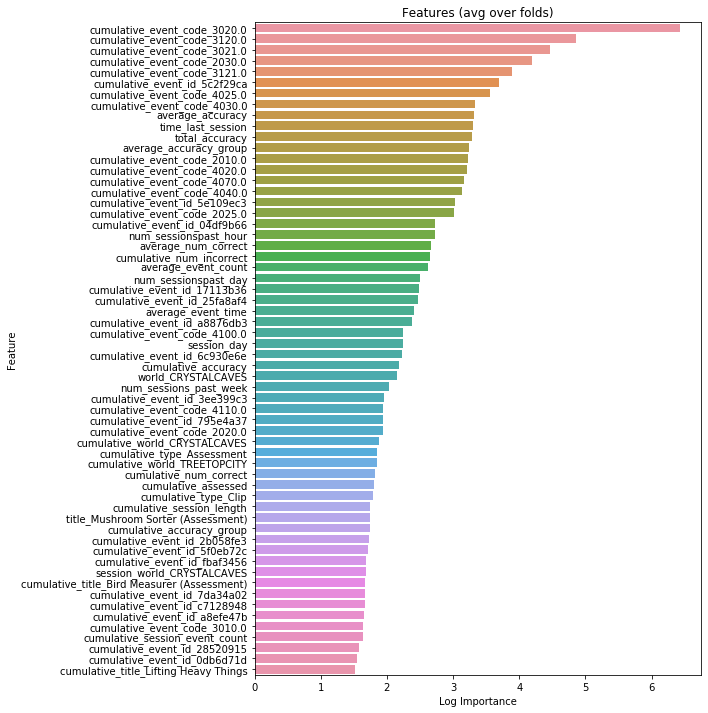

In [129]:
# Ploting feature importances
Importances['Log Importance'] = np.log1p(Importances['Importance'])
plt.figure(figsize=(8, 12))
sns.barplot(x="Log Importance", y="Feature", data=Importances.sort_values(by="Importance", ascending=False))
plt.title('Features (avg over folds)')

In [130]:
def rounder(x, split_1, split_2, split_3):
    if x > split_3:
        return 3
    elif x > split_2:
        return 2
    elif x > split_1:
        return 1
    else:
        return 0

In [131]:
split_space = {
    'split_1': hp.normal('split_1', 0.6, 1.2),
    'split_2': hp.normal('split_2', 1.4, 1.6), 
    'split_3': hp.normal('split_3', 2, 2.4)
}

In [132]:
def optimise_rounder(params, prd_train=best_trial['other_stuff']['prd_train'], y_train=y_train):
    splits = (params['split_1'], params['split_2'], params['split_3'])
    prd_train = prd_train.apply(rounder, args=splits)
    return -quadratic_weighted_kappa(y_train, prd_train)

In [133]:
# Single line bayesian optimization of polynomial function
splits = fmin(fn=optimise_rounder, space=split_space, algo=tpe.suggest, max_evals=1000, 
              rstate=np.random.RandomState(config['random_seed']))
splits

100%|██████████| 1000/1000 [00:07<00:00, 131.69it/s, best loss: -0.7932709496070511]


{'split_1': 0.634137397064771,
 'split_2': 1.7760870352396507,
 'split_3': 2.0578329632448384}

In [134]:
splits = {
    'split_1': 0.634137397064771,
    'split_2': 1.7760870352396507,
    'split_3': 2.0578329632448384
}

In [135]:
args = (splits['split_1'], splits['split_2'], splits['split_3'])
prd_test = pd.Series(best_trial['other_stuff']['prd_test']).apply(rounder, args=args)

In [136]:
submission = pd.DataFrame({'installation_id': X_test.installation_id, 'accuracy_group': prd_test.astype(int)})

In [137]:
# best_trial['other_stuff']['prd_test']

In [138]:
submission.to_csv("../data/submission.csv", index=False)

In [139]:
submission['accuracy_group'].value_counts(normalize=True)

1    1.0
Name: accuracy_group, dtype: float64

In [140]:
y_train.value_counts(normalize=True)

1    0.444944
3    0.370787
0    0.112360
2    0.071910
Name: accuracy_group, dtype: float64